# 在pytorch框架下的数字识别

In [3]:
import torch
import torch.nn as nn
import torch.utils.data as Data
import torchvision
import matplotlib.pyplot as plt
import os

In [4]:
EPOCH = 1               # train the training data n times, to save time, we just train 1 epoch
BATCH_SIZE = 50
lr = 0.001              # learning rate
download_mnist = False

## 判断本地当前目录有无MNIST_data

In [5]:
if not(os.path.exists('./mnist_data/')) or not os.listdir('./mnist_data/'):
    DOWNLOAD_MNIST = True

In [6]:
# 转换 PIL.Image or numpy.ndarray 成torch.FloatTensor (C  H  W), 训练的时候 normalize 成 [0.0, 1.0] 区间
train_data = torchvision.datasets.MNIST(
    root='./mnist_data/',    # 保存或者提取位置
    train=True,         # 训练数据
    transform=torchvision.transforms.ToTensor(),    # 转换 PIL.Image or numpy.ndarray 成
                                                    # torch.FloatTensor (C  H  W), 训练的时候 normalize 成 [0.0, 1.0] 区间
    download=download_mnist,          # 没下载就下载, 下载了就不用再下了
)


In [9]:
print(train_data.train_data.size())                 
print(train_data.train_labels.size())    
print(train_data)
print(train_data[1][0].shape)

torch.Size([60000, 28, 28])
torch.Size([60000])
Dataset MNIST
    Number of datapoints: 60000
    Root location: ./mnist_data/
    Split: Train
torch.Size([1, 28, 28])


## 显示训练集中第4张图

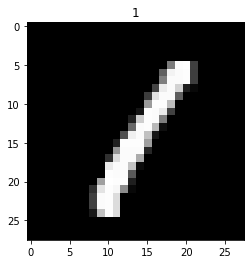

In [10]:
plt.imshow(train_data.train_data[3].numpy(), cmap='gray')
plt.title('%i' % train_data.train_labels[3])
plt.show()

In [18]:
test_data = torchvision.datasets.MNIST(root='./mnist_data/', train=False)

# 批训练 50samples, 1 channel, 28x28 (50, 1, 28, 28)
train_loader = Data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
print(type(train_loader))

# 为了节约时间, 我们测试时只测试前2000个
test_x = torch.unsqueeze(test_data.test_data, dim=1).type(torch.FloatTensor)[:2000]/255.   # shape from (2000, 28, 28) to (2000, 1, 28, 28), value in range(0,1)
test_y = test_data.test_labels[:2000]

<class 'torch.utils.data.dataloader.DataLoader'>


## CNN搭建

In [19]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(  # input shape (1, 28, 28)
            nn.Conv2d(
                in_channels=1,      # input height
                out_channels=16,    # n_filters
                kernel_size=5,      # filter size
                stride=1,           # filter movement/step
                padding=2,      # 如果想要 con2d 出来的图片长宽没有变化, padding=(kernel_size-1)/2 当 stride=1
            ),      # output shape (16, 28, 28)
            nn.ReLU(),    # activation
            nn.MaxPool2d(kernel_size=2),    # 在 2x2 空间里向下采样, output shape (16, 14, 14)
        )
        self.conv2 = nn.Sequential(  # input shape (16, 14, 14)
            nn.Conv2d(16, 32, 5, 1, 2),  # output shape (32, 14, 14)
            nn.ReLU(),  # activation
            nn.MaxPool2d(2),  # output shape (32, 7, 7)
        )
        self.out = nn.Linear(32 * 7 * 7, 10)   # fully connected layer, output 10 classes

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)   # 展平多维的卷积图成 (batch_size, 32 * 7 * 7)
        output = self.out(x)
        return output


## 打印网络模型

In [20]:
cnn = CNN()
print(cnn)  

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)


In [23]:
optimizer = torch.optim.Adam(cnn.parameters(), lr=lr) #optimizer 所有cnn参数
loss_func = nn.CrossEntropyLoss()     #损失函数（类似于TensorFlow中的交叉熵tf.nn.softmax_cross_entropy_with_logits）

# 开始训练和测试

In [25]:
for epoch in range(EPOCH):
    for step, (b_x, b_y) in enumerate(train_loader): 
        output = cnn(b_x)
        loss = loss_func(output, b_y)
        optimizer.zero_grad()            
        loss.backward()                 
        optimizer.step()  
        if step % 50 == 0:
            test_output = cnn(test_x)
            pred_y = torch.max(test_output, 1)[1].data.numpy()
            accuracy = float((pred_y == test_y.data.numpy()).astype(int).sum()) / float(test_y.size(0))
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.data.numpy(), '| test accuracy: %.2f' % accuracy)      

Epoch:  0 | train loss: 2.2824 | test accuracy: 0.18
Epoch:  0 | train loss: 0.5541 | test accuracy: 0.82
Epoch:  0 | train loss: 0.1413 | test accuracy: 0.90
Epoch:  0 | train loss: 0.2657 | test accuracy: 0.91
Epoch:  0 | train loss: 0.0794 | test accuracy: 0.94
Epoch:  0 | train loss: 0.1813 | test accuracy: 0.94
Epoch:  0 | train loss: 0.0670 | test accuracy: 0.95
Epoch:  0 | train loss: 0.0978 | test accuracy: 0.95
Epoch:  0 | train loss: 0.0809 | test accuracy: 0.95
Epoch:  0 | train loss: 0.0672 | test accuracy: 0.96
Epoch:  0 | train loss: 0.1638 | test accuracy: 0.96
Epoch:  0 | train loss: 0.1204 | test accuracy: 0.96
Epoch:  0 | train loss: 0.0397 | test accuracy: 0.97
Epoch:  0 | train loss: 0.1374 | test accuracy: 0.97
Epoch:  0 | train loss: 0.1588 | test accuracy: 0.97
Epoch:  0 | train loss: 0.0238 | test accuracy: 0.97
Epoch:  0 | train loss: 0.1994 | test accuracy: 0.97
Epoch:  0 | train loss: 0.0357 | test accuracy: 0.97
Epoch:  0 | train loss: 0.0338 | test accuracy

###  张量tensor type

In [31]:
x = torch.Tensor([[[1,2,3],[1,2,4]]]).type(torch.FloatTensor)
y = torch.Tensor([[[1,2,3],[1,2,4]]]).type(torch.float32)
print(x.size())
print(x.shape)
print(y)

torch.Size([1, 2, 3])
torch.Size([1, 2, 3])
tensor([[[1., 2., 3.],
         [1., 2., 4.]]])


## 保存网络模型 |  提取网络模型

In [35]:
torch.save(cnn, './net.pkl')
net = torch.load('./net.pkl')
print(net)


CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)


## 测试十张图片

In [37]:
test_output = net(test_x[:10])
pred_y = torch.max(test_output, 1)[1].data.numpy()
print(pred_y, 'prediction number')
print(test_y[:10].numpy(), 'real number')

[7 2 1 0 4 1 4 9 5 9] prediction number
[7 2 1 0 4 1 4 9 5 9] real number
